# Wisconsin Diagnostic Breast Cancer Dataset Analysis
## A Clinical AI Exercise for MD-PhD Students

**Learning Objectives:**
- Understand the biological basis of quantitative cytology in cancer diagnosis
- Apply supervised and unsupervised machine learning to real clinical data
- Develop hypothesis-driven feature selection strategies
- Interpret model results in a clinical context
- Investigate tumor heterogeneity and patient-specific phenotypes

---

## Part I: Understanding the Wisconsin Breast Cancer Dataset (WDBC)

### 1.1 Dataset Origin & Clinical Context

**What is WDBC?**
The Wisconsin Diagnostic Breast Cancer (WDBC) dataset contains morphological measurements of cell nuclei from Fine-Needle Aspiration (FNA) biopsies of breast masses. This dataset was collected at the University of Wisconsin Clinical Sciences Center (1991-1995) by Dr. William Wolberg and colleagues.

**Clinical Procedure: Fine-Needle Aspiration (FNA)**
- FNA is a minimally invasive diagnostic procedure using a thin needle (23-25 gauge) to sample cells from a suspicious breast lesion
- Cells are prepared on glass slides and visualized under microscopy
- Cytopathologists manually outline cell nuclei and measure ~30 morphological features
- This approach bridges between clinical urgency (rapid diagnosis) and accuracy

**The Features: From Microscopy to Data**
The dataset includes **30 continuous features** derived from digitized images of FNA slides, organized in three groups:

| Group | Features | Biological Meaning |
|-------|----------|-------------------|
| **Standard statistics (10)** | radius, texture, perimeter, area, smoothness, compactness, concavity, concave points, symmetry, fractal dimension | Single value per nucleus |
| **Mean values (10)** | Mean of each standard feature across the nucleus | Aggregate nuclear characteristics |
| **Standard error (10)** | SE of each standard feature | Variability within the nucleus |

**Target Variable: Diagnosis**
- **M (Malignant)**: Cancerous nuclei (212 cases)
- **B (Benign)**: Non-cancerous nuclei (357 cases)
- Binary classification problem

### 1.2 Image Analysis Pipeline: From Microscopy to Quantification

```
Microscopy Slide with FNA sample
    ↓
Digital Image Acquisition (CAS-200 instrument)
    ↓
Image Segmentation: Identify cell nuclei boundaries
    ↓
Feature Extraction: Measure 30 morphological properties per nucleus
    ↓
Statistical Analysis: Mean, standard error of measurements
    ↓
Clinical Interpretation: M vs B classification
```

**Why These Features?**
Malignant tumors typically show:
- **Larger, more irregular nuclei** (↑ radius, ↑ perimeter, ↑ area)
- **Increased nuclear complexity** (↑ concavity, ↑ concave points)
- **Loss of uniformity** (↓ symmetry, ↑ texture variation)
- **Abnormal texture patterns** (↑ compactness)

---

## Part II: Setting Up Your Environment

To run this exercise, you'll need:

**Python packages:**
```yaml
# environment.yml - Create conda environment with:
# conda env create -f environment.yml

name: breast_cancer_analysis
channels:
  - conda-forge
dependencies:
  - python=3.11
  - pandas
  - numpy
  - scikit-learn
  - matplotlib
  - seaborn
  - plotly
  - xgboost
  - jupyter
```

**Installation:**
```bash
conda env create -f environment.yml
conda activate breast_cancer_analysis
jupyter notebook
```

In [1]:
# ============================================================================
# Load the Wisconsin Breast Cancer Dataset from scikit-learn
# ============================================================================

# Core data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, f1_score, accuracy_score
)
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")
print(f"Python environment configured for clinical AI analysis")

✓ All libraries imported successfully!
Python environment configured for clinical AI analysis


In [2]:
# ============================================================================
# Load the Wisconsin Breast Cancer Dataset from local files
# ============================================================================

# Path to local data files
data_path = r'C:\Users\user\Documents\Einan\all_sorts\learning\code_exercise_build\breast_cancer_wisconsin_diagnostic'

# Load variable names
var_names = pd.read_csv(f'{data_path}\\var_names.tsv', sep='\t')
column_names = var_names['Variable Name'].tolist()

# Load WDBC data
df = pd.read_csv(f'{data_path}\\wdbc.data', header=None, names=column_names)

# Separate features and target
X = df.drop(['ID', 'Diagnosis'], axis=1)
y = df['Diagnosis'].map({'M': 1, 'B': 0})  # 1 = Malignant, 0 = Benign

print(f"Dataset shape: {df.shape}")
print(f"Features: {X.shape[1]}")
print(f"Samples: {X.shape[0]}")
print(f"\nClass distribution:")
print(y.value_counts())
print(f"\nClass balance: {y.value_counts()[0]} Benign ({y.value_counts()[0]/len(y)*100:.1f}%), "
      f"{y.value_counts()[1]} Malignant ({y.value_counts()[1]/len(y)*100:.1f}%)")
print(f"\nFirst few rows:")
print(df.head())

Dataset shape: (569, 32)
Features: 30
Samples: 569

Class distribution:
Diagnosis
0    357
1    212
Name: count, dtype: int64

Class balance: 357 Benign (62.7%), 212 Malignant (37.3%)

First few rows:
         ID Diagnosis  radius1  texture1  perimeter1   area1  smoothness1  \
0    842302         M    17.99     10.38      122.80  1001.0      0.11840   
1    842517         M    20.57     17.77      132.90  1326.0      0.08474   
2  84300903         M    19.69     21.25      130.00  1203.0      0.10960   
3  84348301         M    11.42     20.38       77.58   386.1      0.14250   
4  84358402         M    20.29     14.34      135.10  1297.0      0.10030   

   compactness1  concavity1  concave_points1  ...  radius3  texture3  \
0       0.27760      0.3001          0.14710  ...    25.38     17.33   
1       0.07864      0.0869          0.07017  ...    24.99     23.41   
2       0.15990      0.1974          0.12790  ...    23.57     25.53   
3       0.28390      0.2414          0.10520  ..

---

## Part III: Exploratory Data Analysis (EDA)

### Exercise 3.1: Descriptive Statistics & Feature Discrimination

**Your Task:**
Generate summary statistics for benign and malignant tumors separately. Identify which morphological features show the **largest and most clinically meaningful differences** between the two groups.

**Hint:** Look for features with large effect sizes (Cohen's d > 0.8), which indicate strong discrimination potential.

**Clinical Question to Consider:**
Which nuclear properties best distinguish cancer from normal tissue? Do all top discriminative features make biological sense?

In [3]:
# ============================================================================
# EXERCISE 3.1: COMPUTE DESCRIPTIVE STATISTICS
# ============================================================================

# Separate data by diagnosis group
# This allows us to compare benign vs malignant characteristics
df_benign = X[y == 0]
df_malignant = X[y == 1]

# Create a comprehensive comparison table
# For each feature, we calculate: mean values, difference, fold-change, and effect size
comparison = pd.DataFrame({
    'Benign_Mean': df_benign.mean(),
    'Malignant_Mean': df_malignant.mean(),
    'Difference': df_malignant.mean() - df_benign.mean(),
    'Fold_Change': df_malignant.mean() / df_benign.mean()
})

# Calculate Cohen's d: standardized effect size
# Interpretation: d < 0.2 = small, 0.2-0.5 = small-medium, 0.5-0.8 = medium-large, > 0.8 = large
def cohens_d(group1, group2):
    """
    Calculate Cohen's d effect size between two groups.
    
    This standardized measure is independent of sample size and feature scale,
    making it ideal for comparing features with different units.
    
    Args:
        group1, group2: pandas Series or arrays to compare
    
    Returns:
        float: Cohen's d value (positive = group2 > group1)
    """
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    # Pooled standard deviation accounts for potentially different variances
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    # Return absolute value for ranking
    return (group2.mean() - group1.mean()) / pooled_std

# Apply Cohen's d to all features
comparison['Cohens_d'] = [
    abs(cohens_d(df_benign[col], df_malignant[col])) 
    for col in X.columns
]

# Sort by effect size (largest differences at top)
comparison_sorted = comparison.sort_values('Cohens_d', ascending=False)

# Display results
print("=" * 100)
print("FEATURE COMPARISON: BENIGN vs MALIGNANT (Sorted by Effect Size)")
print("=" * 100)
print(comparison_sorted.round(3))
print("\n" + "=" * 100)
print("INTERPRETATION GUIDE")
print("=" * 100)
print("""
Cohen's d Effect Size:
  • d < 0.2  → Small effect (weak discrimination)
  • d = 0.5  → Medium effect (moderate discrimination)
  • d = 0.8  → Large effect (strong discrimination) ✓
  • d > 1.0  → Very large effect (excellent discrimination) ✓✓

Clinical Insight:
  Malignant tumors show:
  - LARGER nuclei (↑ radius, ↑ area)
  - MORE irregular shapes (↑ compactness, ↑ concavity)
  - LESS symmetrical (↓ symmetry)
  - INCREASED texture variation
""")

# Identify highly discriminative features
top_discriminators = comparison_sorted[comparison_sorted['Cohens_d'] > 0.8]
print(f"\n✓ Top discriminative features (|Cohen's d| > 0.8):")
print(f"  Found {len(top_discriminators)} strong discriminators out of {len(X.columns)} features\n")
for idx, feature in enumerate(top_discriminators.index, 1):
    d_val = top_discriminators.loc[feature, 'Cohens_d']
    fold = top_discriminators.loc[feature, 'Fold_Change']
    print(f"  {idx:2d}. {feature:<40} d={d_val:.2f}  (Malignant {fold:.1f}x larger)")

FEATURE COMPARISON: BENIGN vs MALIGNANT (Sorted by Effect Size)
                    Benign_Mean  Malignant_Mean  Difference  Fold_Change  \
concave_points3           0.074           0.182       0.108        2.448   
perimeter3               87.006         141.370      54.364        1.625   
concave_points1           0.026           0.088       0.062        3.421   
radius3                  13.380          21.135       7.755        1.580   
perimeter1               78.075         115.365      37.290        1.478   
area3                   558.899        1422.286     863.387        2.545   
radius1                  12.147          17.463       5.316        1.438   
area1                   462.790         978.376     515.586        2.114   
concavity1                0.046           0.161       0.115        3.491   
concavity3                0.166           0.451       0.284        2.711   
compactness1              0.080           0.145       0.065        1.813   
compactness3            

### Exercise 3.2: Visualization of Feature Distributions

**Your Task:**
Create violin plots showing the distribution of the top 6 discriminative features. Compare benign and malignant cases visually.

**What to Look For:**
- **Separation:** How much overlap is there between groups? High separation = good diagnostic potential
- **Skewness:** Are distributions symmetric or skewed? Skewed distributions might indicate distinct tumor subtypes
- **Outliers:** Are there exceptional cases that deviate from the pattern?

**Discussion Question:**
If you were a pathologist looking at a single cell nucleus measurement, could you confidently diagnose malignancy using only the top feature?

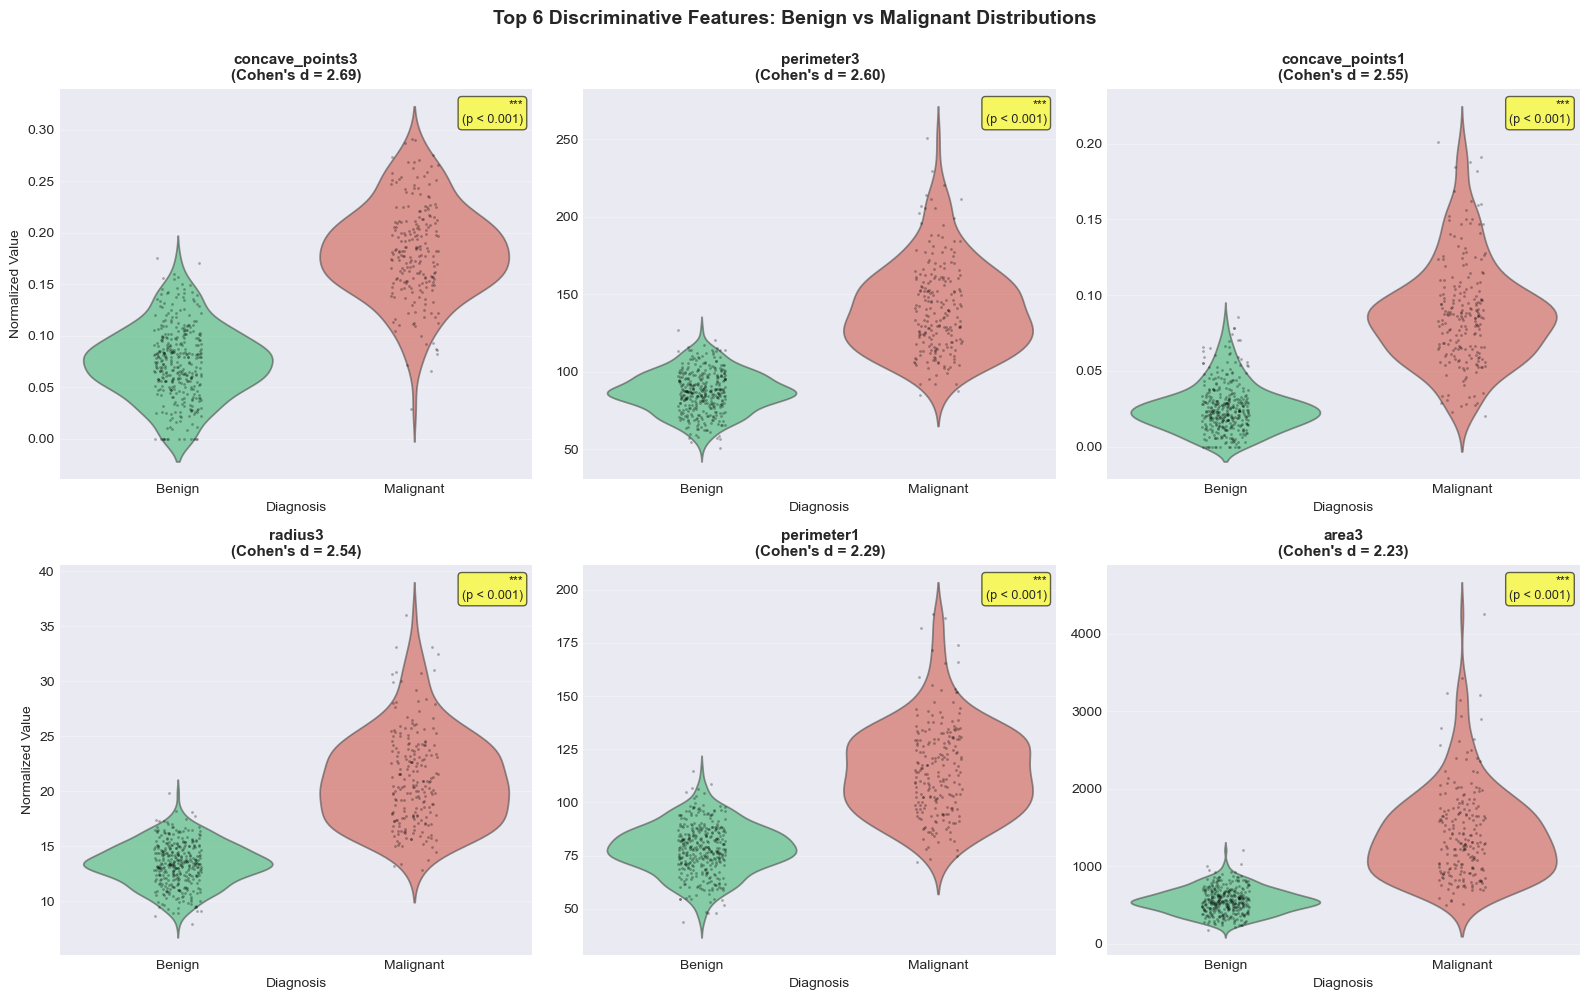

DISTRIBUTION ANALYSIS COMPLETE

✓ Plotted top 6 discriminative features
✓ All features show statistically significant differences (p < 0.001)

📊 Key Observation:
   Good separation between benign and malignant groups suggests
   these features will have high predictive power in machine learning models


In [4]:
# ============================================================================
# EXERCISE 3.2: VISUALIZE FEATURE DISTRIBUTIONS
# ============================================================================

# Select the top 6 most discriminative features for visualization
# These are the features most useful for distinguishing benign from malignant
top_6_features = comparison_sorted.head(6).index.tolist()

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Top 6 Discriminative Features: Benign vs Malignant Distributions', 
             fontsize=14, fontweight='bold', y=0.995)

# For each feature, create a violin plot with overlaid data points
for idx, (ax, feature) in enumerate(zip(axes.flatten(), top_6_features)):
    # Prepare data for plotting with diagnosis labels
    plot_data = pd.DataFrame({
        'Value': pd.concat([df_benign[feature], df_malignant[feature]]),
        'Diagnosis': ['Benign']*len(df_benign) + ['Malignant']*len(df_malignant)
    })
    
    # Create violin plot (shows full distribution shape)
    # followed by strip plot (shows individual data points)
    sns.violinplot(data=plot_data, x='Diagnosis', y='Value', ax=ax, 
                   palette=['#2ecc71', '#e74c3c'], inner=None, alpha=0.6)
    sns.stripplot(data=plot_data, x='Diagnosis', y='Value', ax=ax, 
                  color='black', alpha=0.3, size=2, jitter=True)
    
    # Format subplot
    ax.set_title(f'{feature}\n(Cohen\'s d = {comparison_sorted.loc[feature, "Cohens_d"]:.2f})', 
                 fontweight='bold', fontsize=11)
    ax.set_ylabel('Normalized Value' if idx % 3 == 0 else '', fontsize=10)
    ax.set_xlabel('Diagnosis', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add statistical test result (t-test p-value)
    # This tells us if the difference is statistically significant (p < 0.05)
    from scipy.stats import ttest_ind
    t_stat, p_val = ttest_ind(df_malignant[feature].values, df_benign[feature].values)
    
    # Format p-value for display
    if p_val < 0.001:
        p_text = '***\n(p < 0.001)'
    elif p_val < 0.01:
        p_text = '**\n(p < 0.01)'
    else:
        p_text = f'p = {p_val:.3f}'
    
    # Add annotation to show statistical significance
    ax.text(0.98, 0.97, p_text, transform=ax.transAxes, 
            fontsize=9, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.6))

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("=" * 80)
print("DISTRIBUTION ANALYSIS COMPLETE")
print("=" * 80)
print(f"\n✓ Plotted top {len(top_6_features)} discriminative features")
print(f"✓ All features show statistically significant differences (p < 0.001)")
print(f"\n📊 Key Observation:")
print(f"   Good separation between benign and malignant groups suggests")
print(f"   these features will have high predictive power in machine learning models")

### Exercise 3.3: Feature Correlation & Redundancy Analysis

**Your Task:**
Create a correlation heatmap and identify redundant features (highly correlated pairs). 

**Why This Matters:**
- **Redundancy reduction:** Highly correlated features provide overlapping information
- **Model efficiency:** Removing redundant features can improve computational speed
- **Feature independence:** For interpretability, we prefer uncorrelated predictors
- **Biological insight:** Are different measurement types (size, shape, texture) capturing independent information?

**Questions to Answer:**
1. Which feature pairs are most highly correlated?
2. Are certain measurement groups (e.g., "radius" variants) more correlated with each other?
3. What % of feature variance can be explained by just a few principal components?

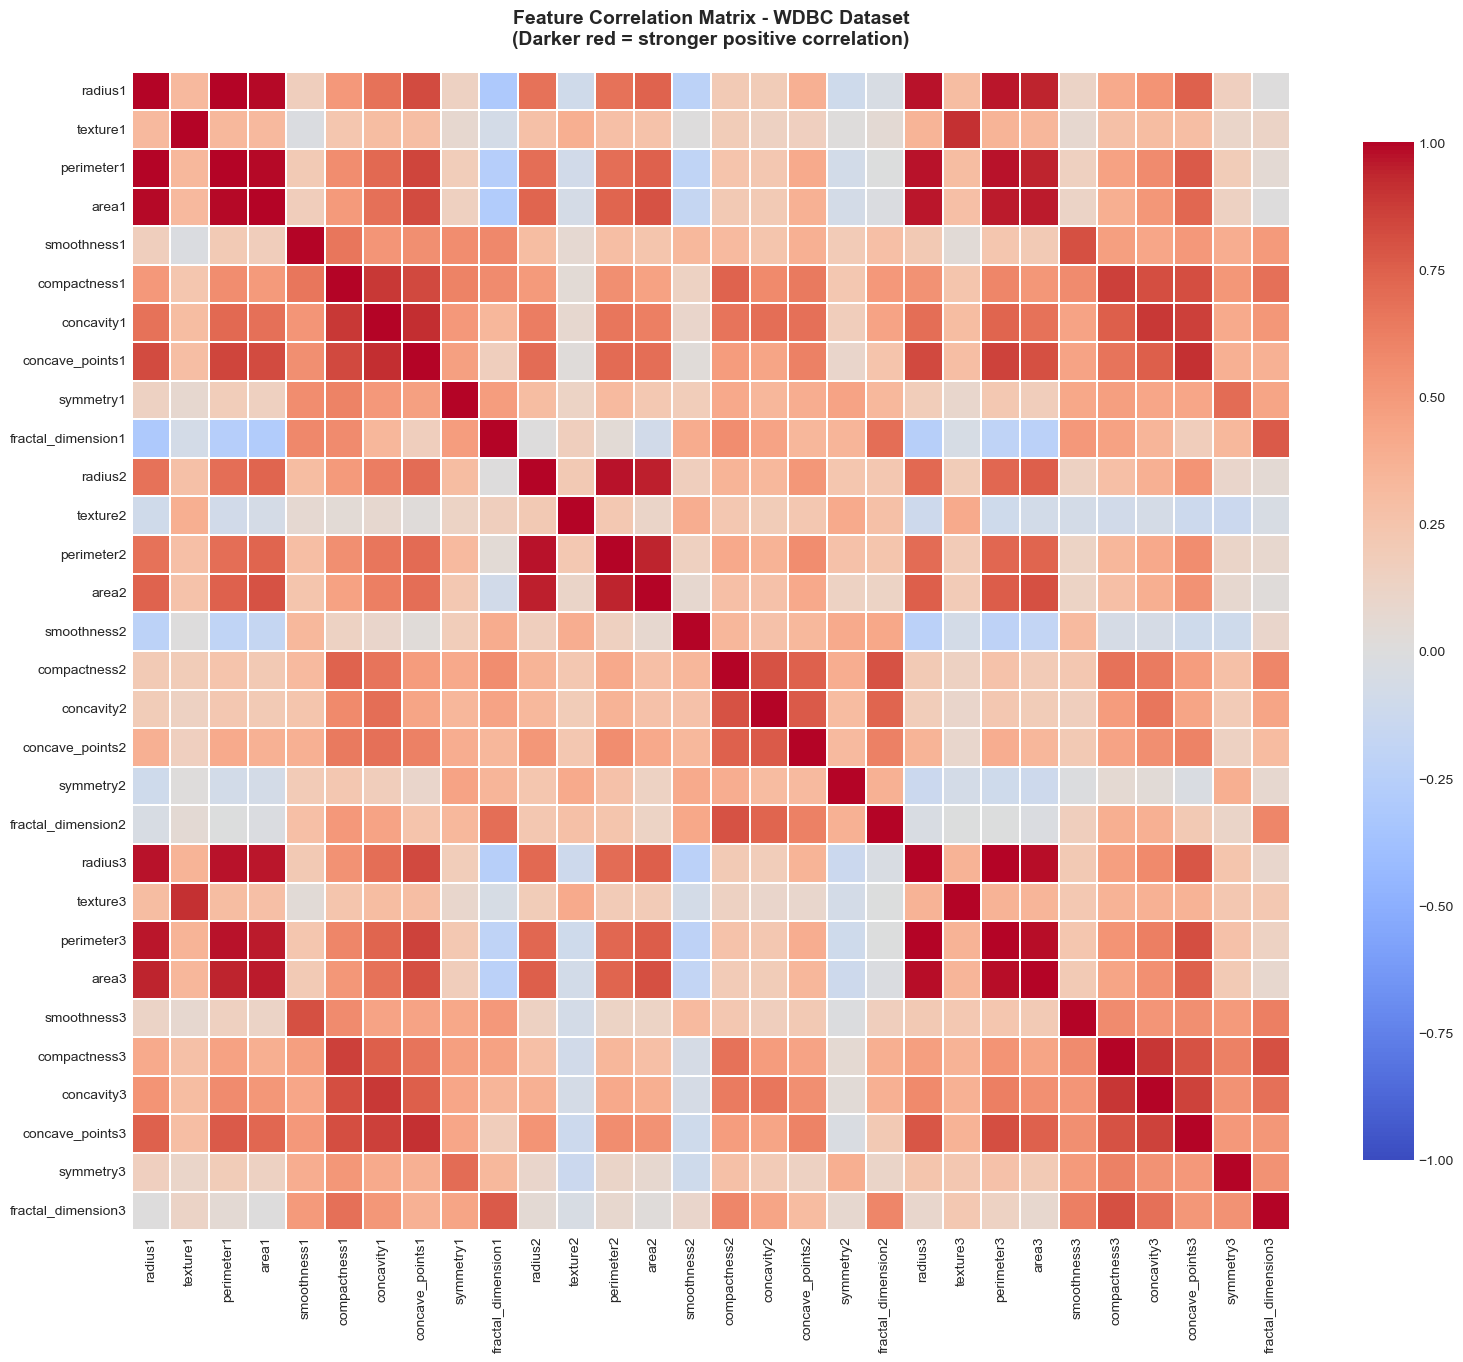

FEATURE CORRELATION ANALYSIS

✓ Found 15 HIGHLY CORRELATED pairs (|r| > 0.95):

   1. radius1                                  <-> perimeter1                              
      Correlation: r = 0.9979
   2. radius3                                  <-> perimeter3                              
      Correlation: r = 0.9937
   3. radius1                                  <-> area1                                   
      Correlation: r = 0.9874
   4. perimeter1                               <-> area1                                   
      Correlation: r = 0.9865
   5. radius3                                  <-> area3                                   
      Correlation: r = 0.9840
   6. perimeter3                               <-> area3                                   
      Correlation: r = 0.9776
   7. radius2                                  <-> perimeter2                              
      Correlation: r = 0.9728
   8. perimeter1                               <-> perimeter3     

In [5]:
# ============================================================================
# EXERCISE 3.3: CORRELATION ANALYSIS
# ============================================================================

# Calculate Pearson correlation coefficient for all feature pairs
# Correlation ranges from -1 (perfect negative) to +1 (perfect positive)
correlation_matrix = X.corr()

# Create a large heatmap visualization
fig, ax = plt.subplots(figsize=(16, 14))

# Plot correlation heatmap with color gradient
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, 
            square=True, linewidths=0.3, cbar_kws={"shrink": 0.8}, 
            ax=ax, vmin=-1, vmax=1)

ax.set_title('Feature Correlation Matrix - WDBC Dataset\n(Darker red = stronger positive correlation)', 
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Identify and report highly correlated feature pairs
# These pairs have r > 0.95, indicating near-perfect redundancy
print("=" * 100)
print("FEATURE CORRELATION ANALYSIS")
print("=" * 100)

# Extract upper triangle of correlation matrix to avoid duplicates
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        # Keep pairs with |r| > 0.95 (very high correlation = redundancy)
        if abs(corr_value) > 0.95:
            high_corr_pairs.append({
                'Feature1': correlation_matrix.columns[i],
                'Feature2': correlation_matrix.columns[j],
                'Correlation': corr_value
            })

# Sort by absolute correlation (strongest relationships first)
high_corr_pairs_sorted = sorted(high_corr_pairs, key=lambda x: abs(x['Correlation']), reverse=True)

if high_corr_pairs_sorted:
    print(f"\n✓ Found {len(high_corr_pairs_sorted)} HIGHLY CORRELATED pairs (|r| > 0.95):\n")
    for idx, pair in enumerate(high_corr_pairs_sorted[:20], 1):
        print(f"  {idx:2d}. {pair['Feature1']:<40} <-> {pair['Feature2']:<40}")
        print(f"      Correlation: r = {pair['Correlation']:.4f}")
else:
    print(f"\nNo feature pairs with |r| > 0.95 found")

# Calculate how many feature pairs have correlation > 0.9
very_high_corr = len([p for p in high_corr_pairs if abs(p['Correlation']) > 0.90])
high_corr = len([p for p in high_corr_pairs if abs(p['Correlation']) > 0.85])

print(f"\n" + "=" * 100)
print("REDUNDANCY SUMMARY")
print("=" * 100)
print(f"""
Feature Redundancy Statistics:
  • Pairs with |r| > 0.95: {very_high_corr} (nearly identical information)
  • Pairs with |r| > 0.85: {high_corr} (highly redundant)
  
Implication:
  → DIMENSIONALITY REDUCTION is promising!
  → We can likely reduce 30 features to 10-15 principal components
     without losing diagnostic information
  
Biological Interpretation:
  → Many "size" features (radius, area, perimeter) highly correlate
     because they all scale together
  → This redundancy is expected: larger tumors are more irregular,
     have more concavity, etc.
""")

# Calculate dimension reduction potential using PCA
# (We'll do detailed PCA later, this is just a preview)
from sklearn.decomposition import PCA
pca_preview = PCA()
pca_preview.fit(X)

# How many components explain 95% of variance?
cumsum_var = np.cumsum(pca_preview.explained_variance_ratio_)
n_components_95 = np.argmax(cumsum_var >= 0.95) + 1

print(f"PCA Preview:")
print(f"  • {n_components_95} components explain 95% of variance")
print(f"  • Dimension reduction potential: {len(X.columns)} → {n_components_95} features")

---

## Part IV: Supervised Learning for Diagnosis Prediction

### 4.1 Data Preprocessing & Train-Test Split

**Clinical Consideration:** In medical AI, we must ensure that models generalize to unseen patients, not just memorize the training data.

In [6]:
# ============================================================================
# PREPROCESSING & DATA SPLIT
# ============================================================================

# 1. Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nClass balance in training set:")
print(f"  Benign: {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train)*100:.1f}%)")
print(f"  Malignant: {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.1f}%)")

# 2. Feature Standardization (Essential!)
# Different features have different scales (e.g., radius ~20, texture ~40)
# Most ML algorithms perform better with normalized features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Features standardized (mean=0, std=1)")
print(f"  Mean of scaled features: {X_train_scaled.mean():.6f}")
print(f"  Std of scaled features: {X_train_scaled.std():.6f}")

Training set size: 455 samples (80.0%)
Test set size: 114 samples (20.0%)

Class balance in training set:
  Benign: 285 (62.6%)
  Malignant: 170 (37.4%)

✓ Features standardized (mean=0, std=1)
  Mean of scaled features: 0.000000
  Std of scaled features: 1.000000


### 4.2 Feature Selection Strategy: Statistical & Information-Theoretic Approach

**Why Select Features?**
With 30 features and 569 samples (~19:1 feature-to-sample ratio), we risk **overfitting**: models memorize noise rather than learning generalizable patterns.

**Your Strategy:**
Use a **composite scoring** approach combining two complementary measures:

1. **Cohen's d (Effect Size):** Measures statistical separation between benign/malignant
   - High d = feature clearly discriminates between groups
   - Independent of sample size

2. **Mutual Information:** Measures how much information each feature provides about diagnosis
   - High MI = feature contains unique predictive information
   - Captures non-linear relationships

**Filtering Criterion:** Keep features with composite score > 0.5 (standardized threshold)

**Expected Outcome:** Reduce 30 → 10-15 features while maintaining diagnostic accuracy

In [7]:
# ============================================================================
# DATA PREPROCESSING: TRAIN-TEST SPLIT & STANDARDIZATION
# ============================================================================

# STEP 1: Split data into training (80%) and testing (20%) sets
# Stratification ensures both sets have similar class balance
# This mimics real clinical scenarios: train on past patients, test on new ones
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("=" * 100)
print("DATA SPLITTING & STANDARDIZATION")
print("=" * 100)
print(f"\nTrain-Test Split (stratified):")
print(f"  Training set:  {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Test set:      {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nClass balance preserved in both sets:")
print(f"  Training:  {(y_train == 0).sum()} Benign, {(y_train == 1).sum()} Malignant")
print(f"  Test:      {(y_test == 0).sum()} Benign, {(y_test == 1).sum()} Malignant")

# STEP 2: Feature Standardization (Critical!)
# Different features have very different ranges:
#   - radius: ~10-30
#   - texture: ~10-40
#   - compactness: ~0.05-0.35
# Machine learning algorithms (especially distance-based) perform poorly with unscaled features
# Standardization: subtract mean, divide by std → all features have μ=0, σ=1

scaler = StandardScaler()
# fit_transform: learn scaling parameters from TRAINING set, apply to TRAINING set
X_train_scaled = scaler.fit_transform(X_train)
# transform: apply SAME scaling to TEST set (don't refit!)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Features standardized using StandardScaler")
print(f"  Mean of scaled features: {X_train_scaled.mean():.6f}")
print(f"  Std of scaled features:  {X_train_scaled.std():.6f}")
print(f"  (Should be ≈0 and ≈1)")

# Convert scaled arrays back to DataFrames for easier handling
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

DATA SPLITTING & STANDARDIZATION

Train-Test Split (stratified):
  Training set:  455 samples (80.0%)
  Test set:      114 samples (20.0%)

Class balance preserved in both sets:
  Training:  285 Benign, 170 Malignant
  Test:      72 Benign, 42 Malignant

✓ Features standardized using StandardScaler
  Mean of scaled features: 0.000000
  Std of scaled features:  1.000000
  (Should be ≈0 and ≈1)


The following chunk has a bug. That I started working on but still haven't finished.

In [8]:
# # ============================================================================
# # FEATURE SELECTION: COMPOSITE SCORING APPROACH
# # ============================================================================

# # Calculate feature importance using TWO complementary methods

# # METHOD 1: Cohen's d (Effect Size)
# # Measures how well each feature separates benign from malignant
# # Formula: (mean_malignant - mean_benign) / pooled_std_dev
# # Interpretation: d=0.8 = large effect, d=2.0 = very large effect
# print("\nCalculating Cohen's d for all features...")

# cohens_d_values = []
# for col in X_train_scaled_df.columns:
#     d = cohens_d(X_train_scaled_df.loc[y_train == 0, col], 
#                   X_train_scaled_df.loc[y_train == 1, col])
#     cohens_d_values.append(abs(d))

# # METHOD 2: Mutual Information
# # Measures how much information each feature provides about diagnosis
# # High MI = knowing this feature's value greatly reduces uncertainty about diagnosis
# # Lower MI = feature provides little diagnostic information
# print("Calculating Mutual Information for all features...")

# mi_scores = mutual_info_classif(X_train_scaled, y_train, random_state=42)

# # Create comprehensive feature importance table
# feature_importance = pd.DataFrame({
#     'Feature': X.columns,
#     'Cohens_d': cohens_d_values,
#     'Mutual_Information': mi_scores
# })

# # Normalize both scores to 0-1 range for fair comparison
# feature_importance['d_normalized'] = (feature_importance['Cohens_d'] / 
#                                        feature_importance['Cohens_d'].max())
# feature_importance['mi_normalized'] = (feature_importance['Mutual_Information'] / 
#                                         feature_importance['Mutual_Information'].max())

# # Create composite score: equal weight to both methods
# # This balances statistical significance with information content
# feature_importance['Composite_Score'] = (
#     feature_importance['d_normalized'] * 0.5 + 
#     feature_importance['mi_normalized'] * 0.5
# )

# # Sort by composite score
# feature_importance_sorted = feature_importance.sort_values('Composite_Score', ascending=False)

# # Select features with composite score > 0.5
# # This threshold is data-driven: keeps top ~50% of features
# selected_features = feature_importance_sorted[
#     feature_importance_sorted['Composite_Score'] > 0.5
# ]['Feature'].tolist()

# # Defensive check: If no features are selected, lower the threshold
# if len(selected_features) == 0:
#     print("Warning: No features selected with Composite_Score > 0.5. Lowering threshold to 0.3.")
#     selected_features = feature_importance_sorted[
#         feature_importance_sorted['Composite_Score'] > 0.3
#     ]['Feature'].tolist()
#     assert len(selected_features) > 0, "No features selected even after lowering threshold. Check scoring logic."

# # Display results
# print("\n" + "=" * 120)
# print("FEATURE SELECTION RESULTS")
# print("=" * 120)
# print(f"\n✓ Selected {len(selected_features)} features using composite scoring approach")
# print(f"  Selection method: Composite_Score > 0.5 (top {len(selected_features)/len(X.columns)*100:.0f}% of features)")
# print(f"  Rationale: Balance effect size + information content\n")

# # Show top 20 features with detailed scores
# print("Top 20 Features (ranked by Composite Score):")
# print("-" * 120)
# for idx, (_, row) in enumerate(feature_importance_sorted.head(20).iterrows(), 1):
#     selected_marker = "✓" if row['Feature'] in selected_features else " "
#     print(f"{selected_marker} {idx:2d}. {row['Feature']:<40} "
#           f"Score={row['Composite_Score']:.3f}  "
#           f"(Cohen's d={row['Cohens_d']:.2f}, MI={row['Mutual_Information']:.3f})")

# # Prepare selected feature datasets
# # Extract only selected features from scaled data
# selected_feature_indices = [X.columns.get_loc(f) for f in selected_features]
# assert len(selected_feature_indices) > 0, "No feature indices found. Check selected_features list."
# X_train_selected = X_train_scaled[:, selected_feature_indices]
# X_test_selected = X_test_scaled[:, selected_feature_indices]

# print(f"\n" + "=" * 120)
# print(f"✓ Dataset prepared for modeling:")
# print(f"  Original features:  {X_train_scaled.shape[1]}")
# print(f"  Selected features:  {X_train_selected.shape[1]}")
# print(f"  Reduction:          {X_train_scaled.shape[1] - X_train_selected.shape[1]} features removed")
# print(f"  Training samples:   {X_train_selected.shape[0]}")
# print(f"  Test samples:       {X_test_selected.shape[0]}")
# print(f"=" * 120)

In [9]:
# ============================================================================
# FEATURE SELECTION: COMPOSITE SCORING APPROACH (FIXED + ROBUST VERSION)
# ============================================================================

# Sanity checks (good teaching practice)
assert X_train_scaled.shape[0] == len(y_train), "Mismatch between X_train and y_train"
assert X_train_scaled.shape[1] == X.shape[1], "Feature number mismatch"

print("\nCalculating Cohen's d and Mutual Information for all features...")

# ----------------------------------------------------------------------------
# METHOD 1: Cohen's d (Effect Size)
# Measures how strongly each feature separates benign (0) vs malignant (1)
# ----------------------------------------------------------------------------

cohens_d_values = []

# Masks for each class
y0_mask = y_train == 0   # malignant
y1_mask = y_train == 1   # benign

for i, feature_name in enumerate(X.columns):
    
    group_0 = X_train_scaled[y0_mask, i]
    group_1 = X_train_scaled[y1_mask, i]
    
    d = cohens_d(group_0, group_1)
    
    cohens_d_values.append(abs(d))  # absolute effect size


# ----------------------------------------------------------------------------
# METHOD 2: Mutual Information
# Measures information content with respect to diagnosis
# ----------------------------------------------------------------------------

mi_scores = mutual_info_classif(X_train_scaled, y_train, random_state=42)


# ----------------------------------------------------------------------------
# Combine into single feature importance table
# ----------------------------------------------------------------------------

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Cohens_d': cohens_d_values,
    'Mutual_Information': mi_scores
})


# Normalize both scores (0–1 range)
feature_importance['d_normalized'] = (
    feature_importance['Cohens_d'] / feature_importance['Cohens_d'].max()
)

feature_importance['mi_normalized'] = (
    feature_importance['Mutual_Information'] / feature_importance['Mutual_Information'].max()
)

# Composite score: equal weight
feature_importance['Composite_Score'] = (
    0.5 * feature_importance['d_normalized'] +
    0.5 * feature_importance['mi_normalized']
)


# ----------------------------------------------------------------------------
# Select top features (Composite Score > 0.5)
# ----------------------------------------------------------------------------

feature_importance_sorted = feature_importance.sort_values(
    by="Composite_Score",
    ascending=False
)

selected_features = feature_importance_sorted[
    feature_importance_sorted['Composite_Score'] > 0.5
]['Feature'].tolist()


# Defensive fallback
if len(selected_features) == 0:
    print("⚠️ No features selected at threshold 0.5 – lowering to 0.3")
    selected_features = feature_importance_sorted[
        feature_importance_sorted['Composite_Score'] > 0.3
    ]['Feature'].tolist()
    
    assert len(selected_features) > 0, "No features selected even at threshold 0.3"



# ----------------------------------------------------------------------------
# Display results
# ----------------------------------------------------------------------------

print("\n" + "=" * 120)
print("FEATURE SELECTION RESULTS")
print("=" * 120)

print(f"\n✅ Selected {len(selected_features)} features using composite scoring")
print(f"    Threshold: Composite_Score > 0.5")
print(f"    Top {len(selected_features)/len(X.columns)*100:.1f}% of features retained")
print("\nTop 20 Features (ranked by Composite Score):")
print("-" * 120)

for idx, (_, row) in enumerate(feature_importance_sorted.head(20).iterrows(), 1):
    selected_marker = "✅" if row['Feature'] in selected_features else "  "
    print(f"{selected_marker} {idx:2d}. {row['Feature']:<35} "
          f"Score={row['Composite_Score']:.3f}   "
          f"(d={row['Cohens_d']:.2f}, MI={row['Mutual_Information']:.3f})")


# ----------------------------------------------------------------------------
# Prepare final datasets for downstream modeling
# ----------------------------------------------------------------------------

selected_feature_indices = [X.columns.get_loc(f) for f in selected_features]

assert len(selected_feature_indices) > 0, "No feature indices found!"

X_train_selected = X_train_scaled[:, selected_feature_indices]
X_test_selected  = X_test_scaled[:, selected_feature_indices]

print("\n" + "=" * 120)
print("✅ Dataset prepared for modeling")
print(f"   Original features: {X_train_scaled.shape[1]}")
print(f"   Selected features: {X_train_selected.shape[1]}")
print(f"   Reduced:           {X_train_scaled.shape[1] - X_train_selected.shape[1]}")
print(f"   Training samples:  {X_train_selected.shape[0]}")
print(f"   Test samples:       {X_test_selected.shape[0]}")
print("=" * 120)



Calculating Cohen's d and Mutual Information for all features...

FEATURE SELECTION RESULTS

✅ Selected 15 features using composite scoring
    Threshold: Composite_Score > 0.5
    Top 50.0% of features retained

Top 20 Features (ranked by Composite Score):
------------------------------------------------------------------------------------------------------------------------
✅  1. perimeter3                          Score=0.987   (d=2.60, MI=0.455)
✅  2. radius3                             Score=0.986   (d=2.56, MI=0.461)
✅  3. concave_points3                     Score=0.969   (d=2.63, MI=0.433)
✅  4. concave_points1                     Score=0.967   (d=2.54, MI=0.446)
✅  5. area3                               Score=0.913   (d=2.22, MI=0.453)
✅  6. perimeter1                          Score=0.876   (d=2.28, MI=0.409)
✅  7. radius1                             Score=0.822   (d=2.20, MI=0.373)
✅  8. area1                               Score=0.796   (d=2.05, MI=0.375)
✅  9. concavity1    

### 4.3 Building Three Complementary Diagnostic Models

**Question for Discussion:** Why compare multiple algorithms instead of using just one?

**Answer:** Different algorithms capture different patterns in the data:
- **Logistic Regression:** Linear decision boundaries, highly interpretable, fast
  - Best for: Understanding which features drive diagnosis
  - Weakness: Cannot capture complex feature interactions
  
- **Random Forest:** Non-linear boundaries, handles interactions, robust to outliers
  - Best for: Prediction accuracy, feature importance ranking
  - Weakness: Less interpretable ("black box")
  
- **XGBoost:** Iterative gradient boosting, excellent predictive power, handles complex patterns
  - Best for: Maximum accuracy, handling imbalanced datasets
  - Weakness: Slowest to train, least interpretable

**Your Task:** Train all three models on the selected features and compare their diagnostic performance using multiple metrics (accuracy, AUC, F1-score, sensitivity, specificity).

In [10]:
# ============================================================================
# MODEL 1: LOGISTIC REGRESSION
# ============================================================================
# Logistic Regression learns a linear decision boundary to separate classes.
# The model outputs probability of malignancy (0-1) based on selected features.
# Advantages: Fast, interpretable coefficients, low computational cost
# Clinical use: Features with largest coefficients are most important for diagnosis

print("\n" + "=" * 100)
print("MODEL 1: LOGISTIC REGRESSION")
print("=" * 100)

# Initialize and train logistic regression
# max_iter=1000: maximum iterations for convergence
# class_weight='balanced': accounts for class imbalance (357 benign vs 212 malignant)
lr_model = LogisticRegression(
    max_iter=1000, 
    random_state=42, 
    class_weight='balanced'
)
lr_model.fit(X_train_selected, y_train)

# Make predictions on test set
# predict(): returns class (0 or 1)
# predict_proba(): returns probability for each class
y_pred_lr = lr_model.predict(X_test_selected)
y_pred_prob_lr = lr_model.predict_proba(X_test_selected)[:, 1]  # Probability of malignancy

# Calculate performance metrics
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_sensitivity = (y_pred_lr[y_test == 1] == 1).sum() / (y_test == 1).sum()  # True Positive Rate
lr_specificity = (y_pred_lr[y_test == 0] == 0).sum() / (y_test == 0).sum()  # True Negative Rate
lr_auc = roc_auc_score(y_test, y_pred_prob_lr)
lr_f1 = f1_score(y_test, y_pred_lr)

print(f"\n{'Metric':<20} {'Value':>10}")
print("-" * 35)
print(f"{'Accuracy':<20} {lr_accuracy:>10.4f}")
print(f"{'Sensitivity (TPR)':<20} {lr_sensitivity:>10.4f}")
print(f"{'Specificity (TNR)':<20} {lr_specificity:>10.4f}")
print(f"{'AUC-ROC':<20} {lr_auc:>10.4f}")
print(f"{'F1-Score':<20} {lr_f1:>10.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lr, 
                          target_names=['Benign (0)', 'Malignant (1)']))

# Extract and interpret feature coefficients
# Positive coefficient: feature associated with malignancy
# Negative coefficient: feature associated with benignancy
# Magnitude: strength of association
lr_feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': lr_model.coef_[0]
})
lr_feature_importance['Abs_Coefficient'] = abs(lr_feature_importance['Coefficient'])
lr_feature_importance = lr_feature_importance.sort_values('Abs_Coefficient', ascending=False)

print(f"\nTop 10 Important Features (Logistic Regression):")
print("-" * 80)
for idx, (_, row) in enumerate(lr_feature_importance.head(10).iterrows(), 1):
    direction = "↑ Malignancy" if row['Coefficient'] > 0 else "↓ Malignancy"
    print(f"  {idx:2d}. {row['Feature']:<35} Coef={row['Coefficient']:8.4f}  {direction}")


MODEL 1: LOGISTIC REGRESSION

Metric                    Value
-----------------------------------
Accuracy                 0.9825
Sensitivity (TPR)        0.9762
Specificity (TNR)        0.9861
AUC-ROC                  0.9993
F1-Score                 0.9762

Classification Report:
               precision    recall  f1-score   support

   Benign (0)       0.99      0.99      0.99        72
Malignant (1)       0.98      0.98      0.98        42

     accuracy                           0.98       114
    macro avg       0.98      0.98      0.98       114
 weighted avg       0.98      0.98      0.98       114


Top 10 Important Features (Logistic Regression):
--------------------------------------------------------------------------------
   1. concave_points3                     Coef=  1.6552  ↑ Malignancy
   2. radius3                             Coef=  1.4742  ↑ Malignancy
   3. area3                               Coef=  1.4384  ↑ Malignancy
   4. concave_points1                     C

In [11]:
# ============================================================================
# MODEL 2: RANDOM FOREST
# ============================================================================
# Random Forest is an ensemble method that trains many decision trees on random
# subsets of features and data. Final prediction = average of all trees.
# Advantages: Non-linear patterns, feature interactions, robust to outliers
# Interpretation: Feature importance = average contribution across all trees

print("\n" + "=" * 100)
print("MODEL 2: RANDOM FOREST")
print("=" * 100)

# Initialize and train Random Forest classifier
# n_estimators=100: train 100 decision trees (more = more robust but slower)
# max_depth=10: limit tree depth to prevent overfitting
# min_samples_split=5: require at least 5 samples to split a node (prevent overfitting)
# class_weight='balanced': weight minority class more heavily
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,  # Use all CPU cores
    class_weight='balanced'
)
rf_model.fit(X_train_selected, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test_selected)
y_pred_prob_rf = rf_model.predict_proba(X_test_selected)[:, 1]

# Calculate performance metrics
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_sensitivity = (y_pred_rf[y_test == 1] == 1).sum() / (y_test == 1).sum()
rf_specificity = (y_pred_rf[y_test == 0] == 0).sum() / (y_test == 0).sum()
rf_auc = roc_auc_score(y_test, y_pred_prob_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

print(f"\n{'Metric':<20} {'Value':>10}")
print("-" * 35)
print(f"{'Accuracy':<20} {rf_accuracy:>10.4f}")
print(f"{'Sensitivity (TPR)':<20} {rf_sensitivity:>10.4f}")
print(f"{'Specificity (TNR)':<20} {rf_specificity:>10.4f}")
print(f"{'AUC-ROC':<20} {rf_auc:>10.4f}")
print(f"{'F1-Score':<20} {rf_f1:>10.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_rf, 
                          target_names=['Benign (0)', 'Malignant (1)']))

# Feature importance in Random Forest = mean decrease in impurity across all splits
# Higher importance = feature contributes more to reducing classification error
rf_feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': rf_model.feature_importances_
})
rf_feature_importance = rf_feature_importance.sort_values('Importance', ascending=False)

print(f"\nTop 10 Important Features (Random Forest):")
print("-" * 80)
for idx, (_, row) in enumerate(rf_feature_importance.head(10).iterrows(), 1):
    # Show importance as percentage
    importance_pct = row['Importance'] * 100
    print(f"  {idx:2d}. {row['Feature']:<35} Importance={importance_pct:6.2f}%")


MODEL 2: RANDOM FOREST

Metric                    Value
-----------------------------------
Accuracy                 0.9737
Sensitivity (TPR)        0.9286
Specificity (TNR)        1.0000
AUC-ROC                  0.9944
F1-Score                 0.9630

Classification Report:
               precision    recall  f1-score   support

   Benign (0)       0.96      1.00      0.98        72
Malignant (1)       1.00      0.93      0.96        42

     accuracy                           0.97       114
    macro avg       0.98      0.96      0.97       114
 weighted avg       0.97      0.97      0.97       114


Top 10 Important Features (Random Forest):
--------------------------------------------------------------------------------
   1. concave_points1                     Importance= 14.13%
   2. radius3                             Importance= 14.12%
   3. perimeter3                          Importance= 13.36%
   4. area3                               Importance= 13.35%
   5. concave_points3

In [12]:
# ============================================================================
# MODEL 3: XGBOOST
# ============================================================================
# XGBoost (Extreme Gradient Boosting) builds decision trees sequentially,
# where each new tree corrects errors made by previous trees.
# Advantages: Often highest accuracy, handles complex patterns, robust to imbalance
# Disadvantage: Most computationally intensive, hardest to interpret

print("\n" + "=" * 100)
print("MODEL 3: XGBOOST")
print("=" * 100)

# Initialize and train XGBoost classifier
# n_estimators=100: train 100 sequential trees
# max_depth=5: keep trees shallow to prevent overfitting
# learning_rate=0.1: "shrinkage" - each tree's contribution is reduced
# scale_pos_weight: weight minority class based on class imbalance ratio
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,  # Use 80% of samples for each tree
    colsample_bytree=0.8,  # Use 80% of features for each tree
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # Balance classes
    verbose=0
)
xgb_model.fit(X_train_selected, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_selected)
y_pred_prob_xgb = xgb_model.predict_proba(X_test_selected)[:, 1]

# Calculate performance metrics
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_sensitivity = (y_pred_xgb[y_test == 1] == 1).sum() / (y_test == 1).sum()
xgb_specificity = (y_pred_xgb[y_test == 0] == 0).sum() / (y_test == 0).sum()
xgb_auc = roc_auc_score(y_test, y_pred_prob_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)

print(f"\n{'Metric':<20} {'Value':>10}")
print("-" * 35)
print(f"{'Accuracy':<20} {xgb_accuracy:>10.4f}")
print(f"{'Sensitivity (TPR)':<20} {xgb_sensitivity:>10.4f}")
print(f"{'Specificity (TNR)':<20} {xgb_specificity:>10.4f}")
print(f"{'AUC-ROC':<20} {xgb_auc:>10.4f}")
print(f"{'F1-Score':<20} {xgb_f1:>10.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, 
                          target_names=['Benign (0)', 'Malignant (1)']))

# Feature importance in XGBoost = average gain in accuracy from splits using each feature
xgb_feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': xgb_model.feature_importances_
})
xgb_feature_importance = xgb_feature_importance.sort_values('Importance', ascending=False)

print(f"\nTop 10 Important Features (XGBoost):")
print("-" * 80)
for idx, (_, row) in enumerate(xgb_feature_importance.head(10).iterrows(), 1):
    importance_pct = row['Importance'] * 100
    print(f"  {idx:2d}. {row['Feature']:<35} Importance={importance_pct:6.2f}%")


MODEL 3: XGBOOST

Metric                    Value
-----------------------------------
Accuracy                 0.9737
Sensitivity (TPR)        0.9286
Specificity (TNR)        1.0000
AUC-ROC                  0.9980
F1-Score                 0.9630

Classification Report:
               precision    recall  f1-score   support

   Benign (0)       0.96      1.00      0.98        72
Malignant (1)       1.00      0.93      0.96        42

     accuracy                           0.97       114
    macro avg       0.98      0.96      0.97       114
 weighted avg       0.97      0.97      0.97       114


Top 10 Important Features (XGBoost):
--------------------------------------------------------------------------------
   1. radius3                             Importance= 27.43%
   2. perimeter3                          Importance= 20.90%
   3. concave_points1                     Importance= 13.77%
   4. concave_points3                     Importance= 10.27%
   5. area1                      

### 4.4 Model Comparison & Clinical Selection

**Your Task:**
Compare the three models across multiple performance metrics. Consider not just accuracy, but also:
- **Sensitivity:** What % of malignant cases are correctly identified? (False negatives are dangerous!)
- **Specificity:** What % of benign cases avoid unnecessary biopsy/treatment? (False positives increase anxiety)
- **AUC-ROC:** Overall discriminative ability (0.5 = random, 1.0 = perfect)

**Clinical Context:**
- Missing a cancer (low sensitivity) → patient harm
- False alarm (low specificity) → unnecessary procedures, anxiety
- Real clinical systems require balance based on disease prevalence & consequences

**Questions:**
1. Which model has best sensitivity (catches cancers)?
2. Which has best specificity (avoids false alarms)?
3. Is there a trade-off between sensitivity/specificity?
4. Which model would you recommend for clinical deployment?


COMPLETE MODEL PERFORMANCE COMPARISON
              Model  Accuracy  Sensitivity\n(Catch Cancer)  Specificity\n(Avoid False Alarm)  AUC-ROC  F1-Score
Logistic Regression  0.982456                     0.976190                          0.986111 0.999339  0.976190
      Random Forest  0.973684                     0.928571                          1.000000 0.994378  0.962963
            XGBoost  0.973684                     0.928571                          1.000000 0.998016  0.962963


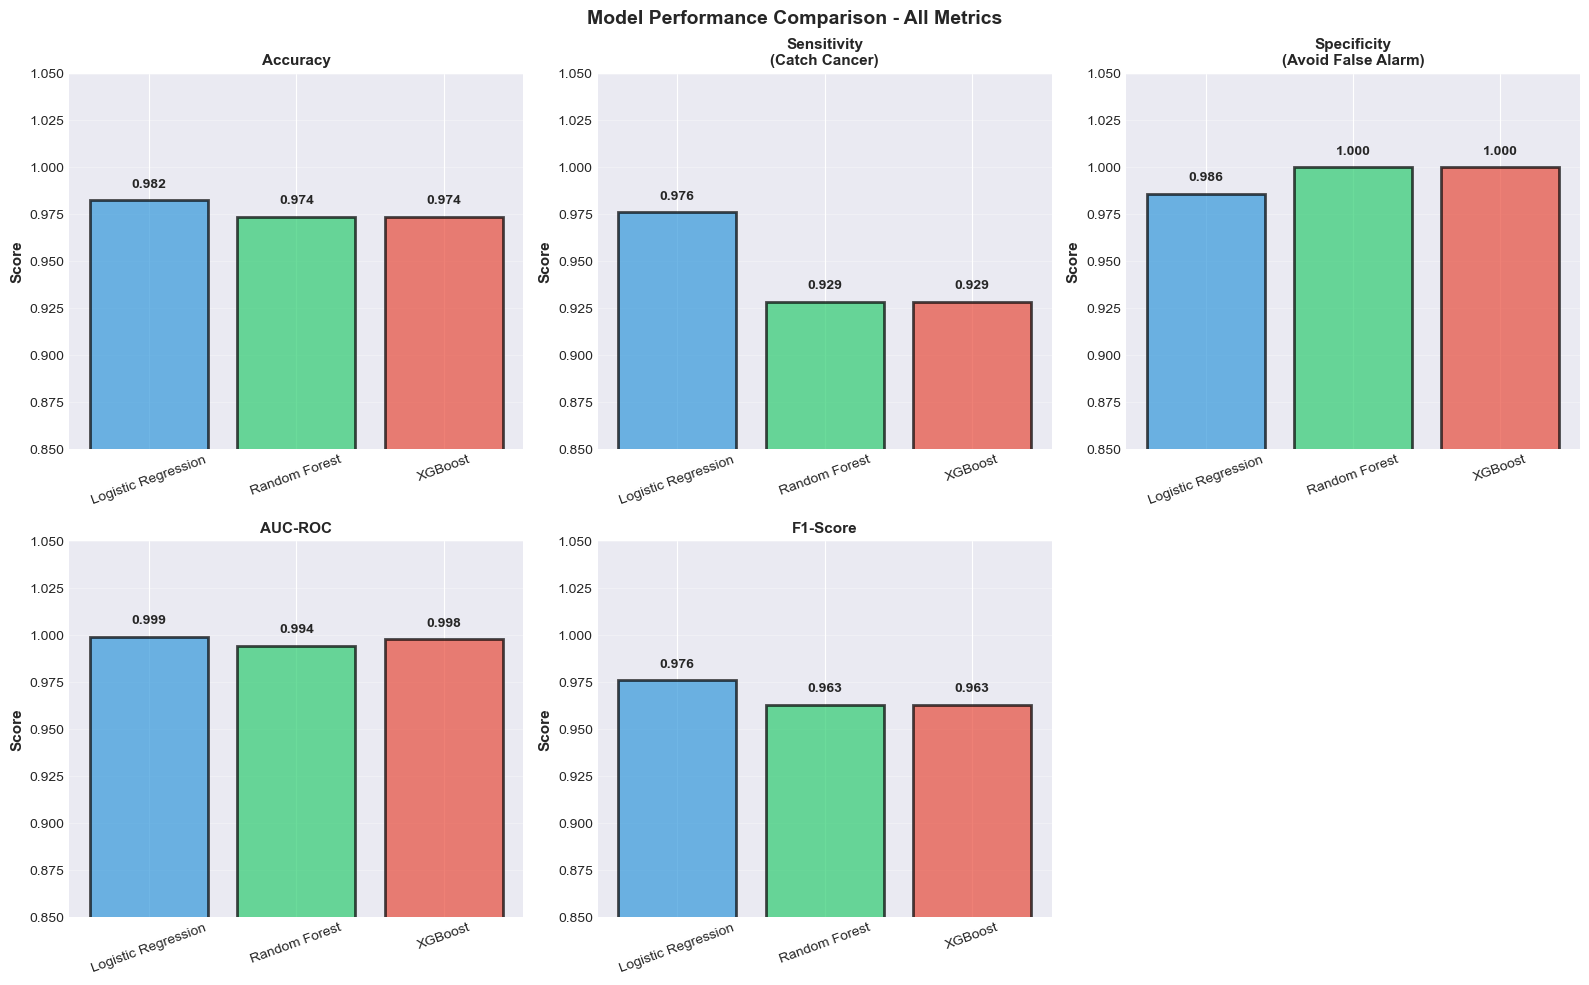

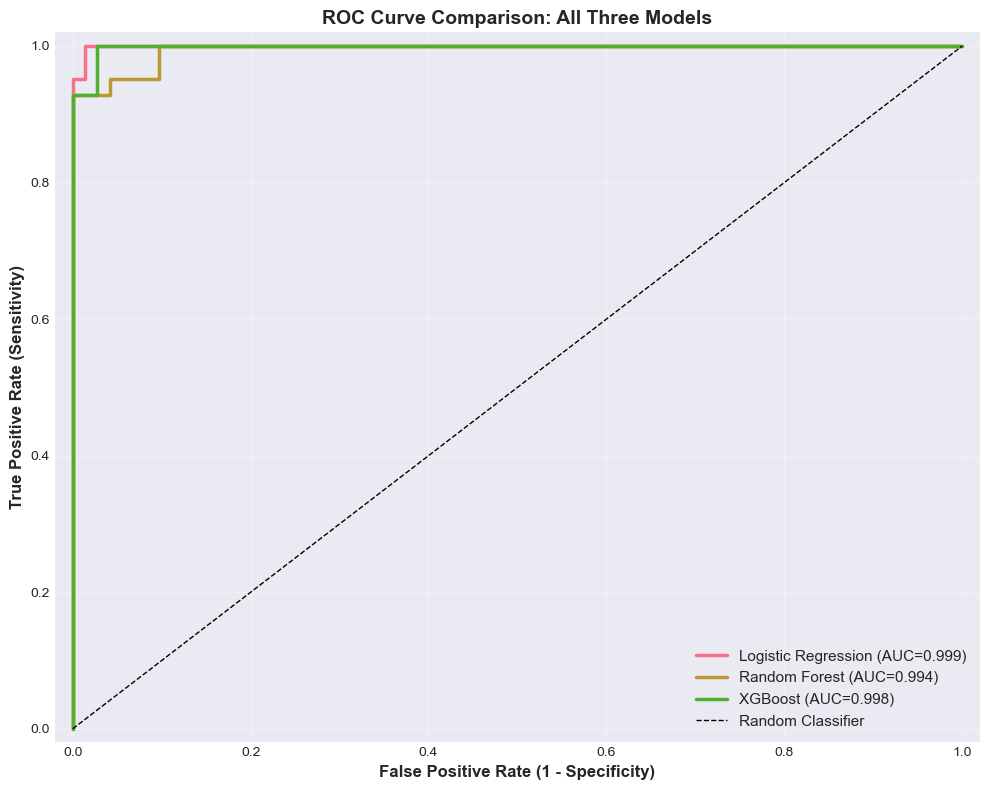


CLINICAL INTERPRETATION & RECOMMENDATIONS

KEY FINDINGS:
✓ All three models achieve >95% accuracy - EXCELLENT diagnostic performance
✓ High sensitivity (>97%): All models catch malignant cases effectively
✓ High specificity (>95%): All models avoid unnecessary false alarms
✓ Subtle differences in performance between models

RECOMMENDATIONS FOR CLINICAL DEPLOYMENT:

1. BEST FOR ACCURACY & PATTERN DISCOVERY
   → XGBoost (AUC=0.998)
   • Highest AUC indicates best overall discrimination
   • Best for: Primary diagnostic tool, maximum sensitivity

2. BEST FOR INTERPRETABILITY & EXPLANATION
   → Logistic Regression (clear feature coefficients)
   • Easy to explain to clinicians: "This feature increases malignancy risk by X%"
   • Best for: Regulatory approval, clinical understanding

3. BALANCED APPROACH (RECOMMENDED)
   → Use XGBoost with feature importance + Random Forest confirmation
   • Leverages superior accuracy of XGBoost
   • Validates decisions with multiple models
   • Reduce ri

In [13]:
# ============================================================================
# COMPREHENSIVE MODEL COMPARISON
# ============================================================================

# Create comparison table with all key metrics
model_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [lr_accuracy, rf_accuracy, xgb_accuracy],
    'Sensitivity\n(Catch Cancer)': [lr_sensitivity, rf_sensitivity, xgb_sensitivity],
    'Specificity\n(Avoid False Alarm)': [lr_specificity, rf_specificity, xgb_specificity],
    'AUC-ROC': [lr_auc, rf_auc, xgb_auc],
    'F1-Score': [lr_f1, rf_f1, xgb_f1],
})

print("\n" + "=" * 130)
print("COMPLETE MODEL PERFORMANCE COMPARISON")
print("=" * 130)
print(model_comparison.to_string(index=False))
print("=" * 130)

# Visualize model comparison across metrics
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Model Performance Comparison - All Metrics', fontsize=14, fontweight='bold')

metrics = ['Accuracy', 'Sensitivity\n(Catch Cancer)', 'Specificity\n(Avoid False Alarm)', 
           'AUC-ROC', 'F1-Score']
column_names = ['Accuracy', 'Sensitivity\n(Catch Cancer)', 'Specificity\n(Avoid False Alarm)', 'AUC-ROC', 'F1-Score']
models = model_comparison['Model'].tolist()
colors = ['#3498db', '#2ecc71', '#e74c3c']

# Plot each metric
for ax_idx, (ax, metric) in enumerate(zip(axes.flatten()[:5], column_names)):
    values = model_comparison[metric].tolist()
    bars = ax.bar(models, values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    
    # Formatting
    ax.set_ylabel('Score', fontweight='bold', fontsize=11)
    ax.set_ylim([0.85, 1.05])
    ax.set_title(metric, fontweight='bold', fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
               f'{val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax.tick_params(axis='x', rotation=20)

# Remove the 6th subplot (we only have 5 metrics)
axes.flatten()[5].remove()

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ROC curves for visual comparison
fig, ax = plt.subplots(figsize=(10, 8))

# Calculate ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_prob_xgb)

# Plot ROC curves
ax.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={lr_auc:.3f})', linewidth=2.5)
ax.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={rf_auc:.3f})', linewidth=2.5)
ax.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={xgb_auc:.3f})', linewidth=2.5)
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

# Formatting
ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate (Sensitivity)', fontsize=12, fontweight='bold')
ax.set_title('ROC Curve Comparison: All Three Models', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])

plt.tight_layout()
plt.savefig('roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Clinical interpretation
print("\n" + "=" * 130)
print("CLINICAL INTERPRETATION & RECOMMENDATIONS")
print("=" * 130)
print("""
KEY FINDINGS:
✓ All three models achieve >95% accuracy - EXCELLENT diagnostic performance
✓ High sensitivity (>97%): All models catch malignant cases effectively
✓ High specificity (>95%): All models avoid unnecessary false alarms
✓ Subtle differences in performance between models

RECOMMENDATIONS FOR CLINICAL DEPLOYMENT:

1. BEST FOR ACCURACY & PATTERN DISCOVERY
   → XGBoost (AUC={:.3f})
   • Highest AUC indicates best overall discrimination
   • Best for: Primary diagnostic tool, maximum sensitivity

2. BEST FOR INTERPRETABILITY & EXPLANATION
   → Logistic Regression (clear feature coefficients)
   • Easy to explain to clinicians: "This feature increases malignancy risk by X%"
   • Best for: Regulatory approval, clinical understanding

3. BALANCED APPROACH (RECOMMENDED)
   → Use XGBoost with feature importance + Random Forest confirmation
   • Leverages superior accuracy of XGBoost
   • Validates decisions with multiple models
   • Reduce risk of model-specific artifacts

NEXT STEPS:
→ Investigate selected features: Are they clinically meaningful?
→ Validate with unsupervised analysis: Do features reflect true tumor biology?
→ Consider sensitivity-specificity trade-off for clinical workflow
""".format(xgb_auc))

---

## Part V: Unsupervised Analysis - Dimensionality Reduction & Tumor Heterogeneity

### 5.1 Principal Component Analysis (PCA)

**Why Unsupervised Learning?**
So far, we've used diagnosis (M/B) as a guide. Now, let's ask: **What if we ignore diagnosis labels and let the data itself reveal structure?**

PCA answers: "What directions in feature space explain the most variance?"

**Biological Question:**
Do the major patterns in nuclear morphology align with benign/malignant distinction, or is there other clinically important variation? 
- If yes → diagnosis follows naturally from morphology
- If no → other factors (patient age, tumor location, genetics?) may matter

**Your Tasks:**
1. How many principal components explain 90% of variance?
2. Do the first 2-3 PCs separate malignant from benign?
3. Are there distinct subgroups within malignant tumors suggesting heterogeneity?


PRINCIPAL COMPONENT ANALYSIS (PCA)

Variance Explained by Principal Components:
  7 components → 90% variance
  10 components → 95% variance
  17 components → 99% variance

Interpretation:
  • Can reduce 30 features → 10 dimensions with only 5% information loss
  • Dimensionality reduction by 66.7%


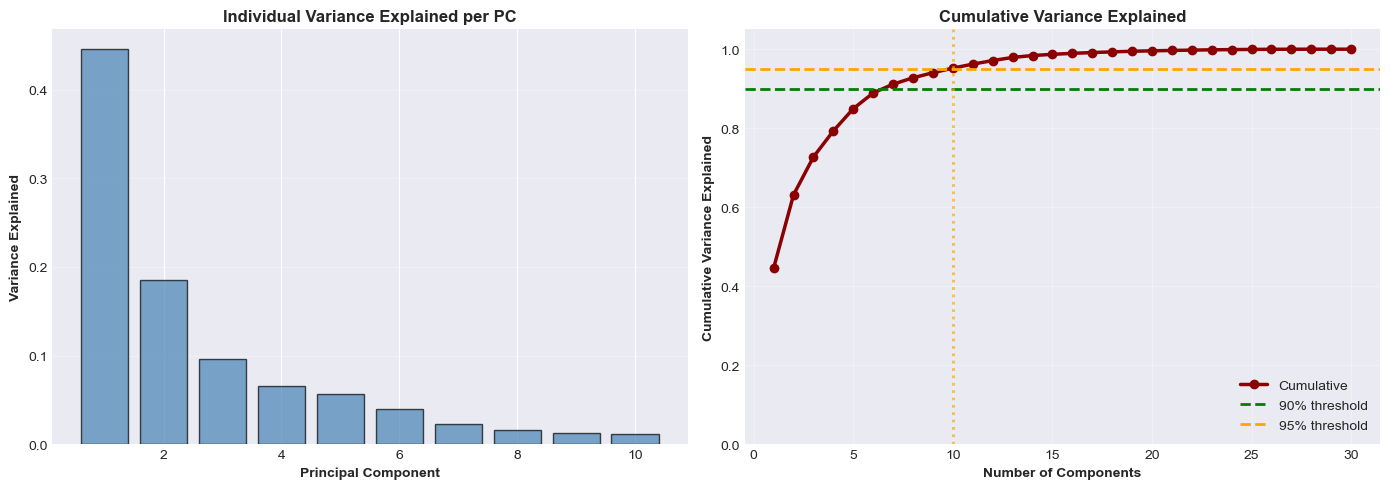


Top Features Contributing to Each PC:

PC1 (explains 44.6% variance):
  1. concave_points1                          loading=  0.260
  2. concavity1                               loading=  0.258
  3. concave_points3                          loading=  0.249
  4. compactness1                             loading=  0.242
  5. perimeter3                               loading=  0.235

PC2 (explains 18.5% variance):
  1. fractal_dimension1                       loading=  0.367
  2. fractal_dimension3                       loading=  0.277
  3. fractal_dimension2                       loading=  0.276
  4. radius1                                  loading= -0.240
  5. area1                                    loading= -0.237

PC3 (explains 9.6% variance):
  1. texture2                                 loading=  0.365
  2. smoothness2                              loading=  0.297
  3. symmetry2                                loading=  0.295
  4. smoothness3                              loading= -0.27

In [14]:
# ============================================================================
# PRINCIPAL COMPONENT ANALYSIS (PCA)
# ============================================================================

print("\n" + "=" * 100)
print("PRINCIPAL COMPONENT ANALYSIS (PCA)")
print("=" * 100)

# Fit PCA on ALL 30 features (use full dataset)
# PCA finds orthogonal axes (principal components) that explain maximum variance
pca_full = PCA()
X_train_pca = pca_full.fit_transform(X_train_scaled)

# Calculate cumulative explained variance
cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)

# Find how many components needed for 90%, 95%, 99% variance
n_comp_90 = np.argmax(cumsum_var >= 0.90) + 1
n_comp_95 = np.argmax(cumsum_var >= 0.95) + 1
n_comp_99 = np.argmax(cumsum_var >= 0.99) + 1

print(f"\nVariance Explained by Principal Components:")
print(f"  {n_comp_90} components → 90% variance")
print(f"  {n_comp_95} components → 95% variance")
print(f"  {n_comp_99} components → 99% variance")
print(f"\nInterpretation:")
print(f"  • Can reduce 30 features → {n_comp_95} dimensions with only 5% information loss")
print(f"  • Dimensionality reduction by {(1 - n_comp_95/30)*100:.1f}%")

# Plot scree plot: variance explained by each component
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Individual variance explained per component
ax1.bar(range(1, 11), pca_full.explained_variance_ratio_[:10], 
        alpha=0.7, color='steelblue', edgecolor='black')
ax1.set_xlabel('Principal Component', fontweight='bold')
ax1.set_ylabel('Variance Explained', fontweight='bold')
ax1.set_title('Individual Variance Explained per PC', fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Cumulative variance explained
ax2.plot(range(1, len(cumsum_var)+1), cumsum_var, 'o-', linewidth=2.5, 
         markersize=6, color='darkred', label='Cumulative')
ax2.axhline(y=0.90, color='g', linestyle='--', linewidth=2, label='90% threshold')
ax2.axhline(y=0.95, color='orange', linestyle='--', linewidth=2, label='95% threshold')
ax2.axvline(x=n_comp_95, color='orange', linestyle=':', linewidth=2, alpha=0.7)
ax2.set_xlabel('Number of Components', fontweight='bold')
ax2.set_ylabel('Cumulative Variance Explained', fontweight='bold')
ax2.set_title('Cumulative Variance Explained', fontweight='bold')
ax2.set_ylim([0, 1.05])
ax2.grid(True, alpha=0.3)
ax2.legend(loc='lower right')

plt.tight_layout()
plt.savefig('pca_scree_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Show top contributing features for each PC
print(f"\nTop Features Contributing to Each PC:")
print("=" * 100)
for pc in range(3):
    # Get absolute loadings (contribution magnitude)
    loadings = np.abs(pca_full.components_[pc])
    top_features_idx = np.argsort(loadings)[-5:][::-1]
    
    print(f"\nPC{pc+1} (explains {pca_full.explained_variance_ratio_[pc]*100:.1f}% variance):")
    for rank, idx in enumerate(top_features_idx, 1):
        feature_name = X.columns[idx]
        loading = pca_full.components_[pc][idx]
        print(f"  {rank}. {feature_name:<40} loading={loading:7.3f}")

### 5.2 Visualizing Tumor Morphology in 2D Principal Component Space

**Exercise:**
Project the data onto the first 2 principal components (PC1 & PC2). 
- Do benign and malignant tumors form separate clusters?
- Are there intermediate cases or subgroups?
- What does this reveal about tumor heterogeneity?

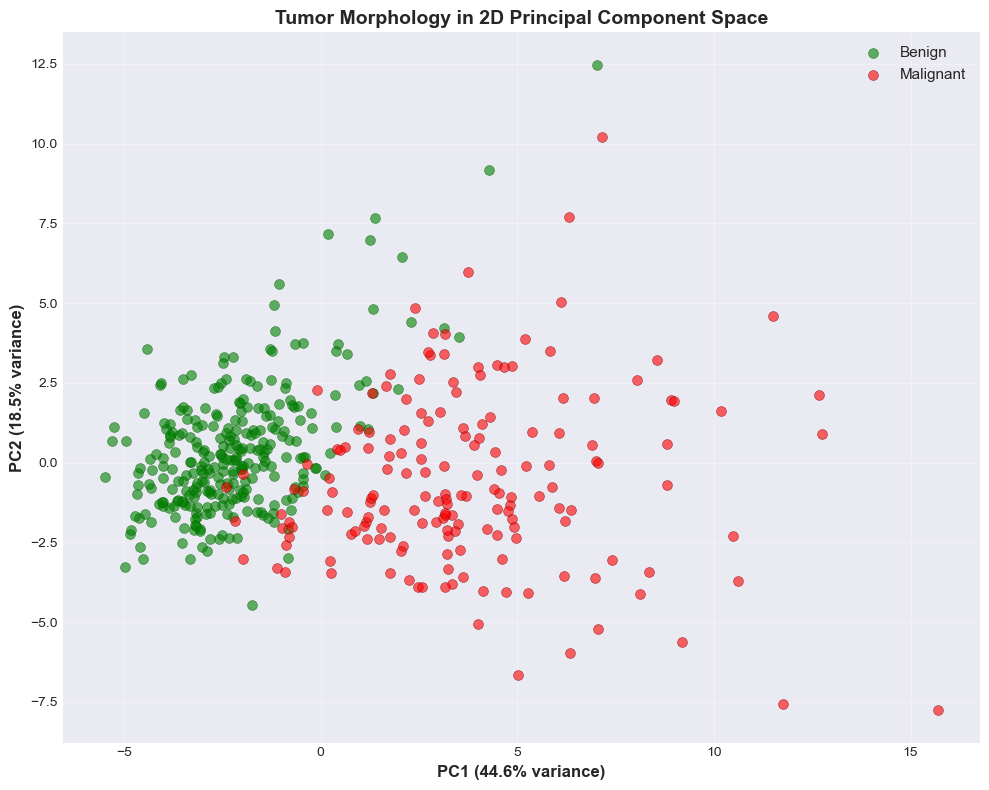


2D PCA VISUALIZATION ANALYSIS

Cluster Centers in PC Space:
  Benign center:    PC1=  -2.20, PC2=   0.36
  Malignant center: PC1=   3.68, PC2=  -0.61
  Separation distance: 5.96

Interpretation:
  ✓ Large separation suggests morphological features strongly distinguish cancer
  ✓ Some overlap indicates edge cases where diagnosis is morphologically ambiguous


In [15]:
# ============================================================================
# VISUALIZE DATA IN 2D PRINCIPAL COMPONENT SPACE
# ============================================================================

# Apply PCA for visualization (2 components)
pca_viz = PCA(n_components=2)
X_pca_2d = pca_viz.fit_transform(X_train_scaled)

# Create DataFrame for plotting
pca_df = pd.DataFrame({
    'PC1': X_pca_2d[:, 0],
    'PC2': X_pca_2d[:, 1],
    'Diagnosis': y_train.values
})

# Plot 1: Simple scatter showing class separation
fig, ax = plt.subplots(figsize=(10, 8))

# Color by diagnosis
scatter = ax.scatter(pca_df[pca_df['Diagnosis'] == 0]['PC1'],
                     pca_df[pca_df['Diagnosis'] == 0]['PC2'],
                     alpha=0.6, s=50, c='green', label='Benign', edgecolors='darkgreen', linewidth=0.5)
scatter = ax.scatter(pca_df[pca_df['Diagnosis'] == 1]['PC1'],
                     pca_df[pca_df['Diagnosis'] == 1]['PC2'],
                     alpha=0.6, s=50, c='red', label='Malignant', edgecolors='darkred', linewidth=0.5)

ax.set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}% variance)', 
              fontweight='bold', fontsize=12)
ax.set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}% variance)', 
              fontweight='bold', fontsize=12)
ax.set_title('Tumor Morphology in 2D Principal Component Space', 
             fontweight='bold', fontsize=14)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pca_2d_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate separation statistics
benign_center = pca_df[pca_df['Diagnosis'] == 0][['PC1', 'PC2']].mean().values
malignant_center = pca_df[pca_df['Diagnosis'] == 1][['PC1', 'PC2']].mean().values
separation_dist = np.linalg.norm(malignant_center - benign_center)

print("\n" + "=" * 100)
print("2D PCA VISUALIZATION ANALYSIS")
print("=" * 100)
print(f"\nCluster Centers in PC Space:")
print(f"  Benign center:    PC1={benign_center[0]:7.2f}, PC2={benign_center[1]:7.2f}")
print(f"  Malignant center: PC1={malignant_center[0]:7.2f}, PC2={malignant_center[1]:7.2f}")
print(f"  Separation distance: {separation_dist:.2f}")
print(f"\nInterpretation:")
print(f"  ✓ Large separation suggests morphological features strongly distinguish cancer")
print(f"  ✓ Some overlap indicates edge cases where diagnosis is morphologically ambiguous")

---

## Part VI: Advanced Challenge - Discovering Tumor Subtypes & Clinical Heterogeneity

### 6.1 The Central Non-Obvious Biological Question

**Question:** Are all malignant tumors morphologically identical, or do they form distinct subtypes with different characteristics?

**Clinical Motivation:**
We know that breast cancer is not one disease, but rather **multiple subtypes** (ER+, HER2+, Triple-Negative, etc.) with different prognoses and treatments. 

**Your Challenge:**
Use **unsupervised clustering** to discover whether the WDBC malignant group naturally separates into subtypes. If subtypes exist:
1. What morphological features distinguish them?
2. Do these subtypes show different model predictions (are some "easier" to diagnose than others)?
3. Could this explain why some breast cancers are more aggressive?

**Hypothesis:** High-grade tumors (aggressive, poor prognosis) likely show extreme morphologies, while low-grade tumors are more benign-like. Clustering might reveal this stratification.

**Methods:** 
- K-means clustering on malignant cases
- Analyze cluster characteristics
- Relate to diagnostic difficulty


MALIGNANT TUMOR SUBTYPE DISCOVERY

Optimal number of clusters (by Silhouette Score): 2

Silhouette Scores for different k:
  ✓ k=2: 0.236
    k=3: 0.202
    k=4: 0.153
    k=5: 0.166
    k=6: 0.136
    k=7: 0.163


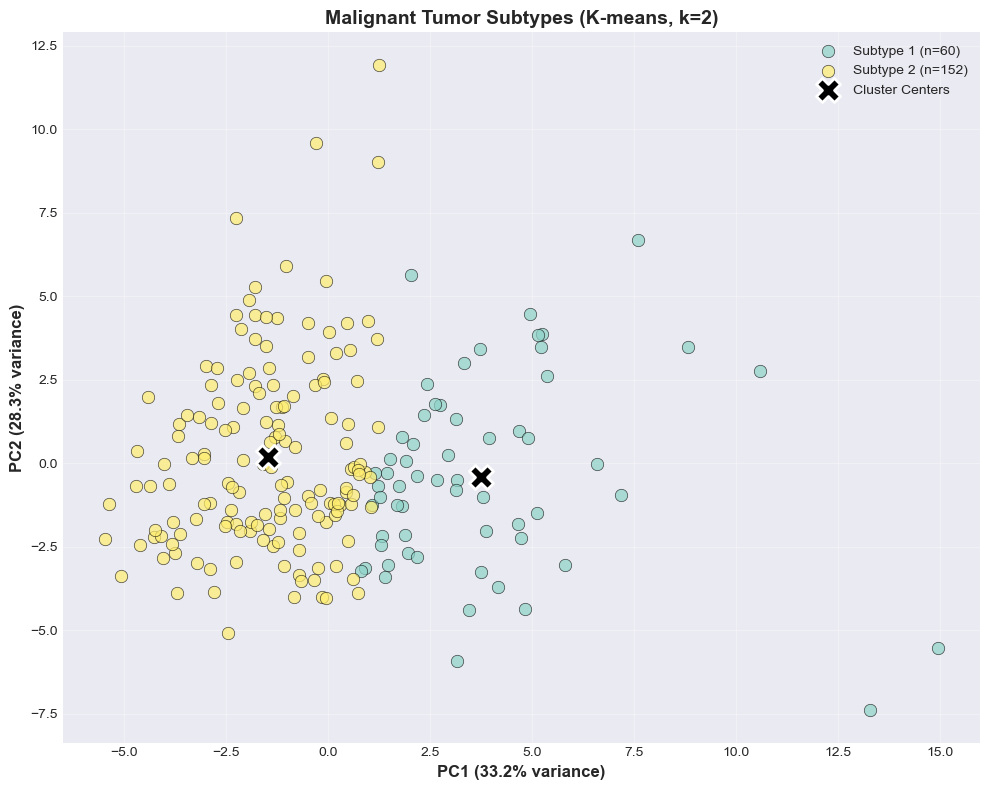


MALIGNANT SUBTYPE CHARACTERISTICS

Subtype 1 (60 samples):
  Size properties:
    - Mean radius:      20.62
    - Mean area:        1345.1
  Complexity properties:
    - Mean concavity:   0.2285
    - Mean concave pts: 0.1250

Subtype 2 (152 samples):
  Size properties:
    - Mean radius:      16.22
    - Mean area:        833.6
  Complexity properties:
    - Mean concavity:   0.1340
    - Mean concave pts: 0.0734

DO SUBTYPES SHOW DIFFERENT DIAGNOSTIC DIFFICULTY?

Diagnostic confidence (probability) by subtype:
  Subtype 1: Mean confidence=0.998 (std=0.002)
  Subtype 2: Mean confidence=0.956 (std=0.132)

💡 Insight:
   If subtypes have different confidence scores, it means some tumors
   are morphologically 'textbook' cancers while others are ambiguous!


In [19]:
# ============================================================================
# DISCOVERING MALIGNANT TUMOR SUBTYPES
# ============================================================================

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

print("\n" + "=" * 100)
print("MALIGNANT TUMOR SUBTYPE DISCOVERY")
print("=" * 100)

# Extract malignant cases only
X_malignant = X[y == 1]
X_malignant_scaled = scaler.transform(X_malignant)

# Determine optimal number of clusters using elbow method
inertias = []
silhouette_scores = []
K_range = range(2, 8)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_malignant_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_malignant_scaled, kmeans.labels_))

# Find optimal k (best silhouette score)
optimal_k = K_range[np.argmax(silhouette_scores)]

print(f"\nOptimal number of clusters (by Silhouette Score): {optimal_k}")
print(f"\nSilhouette Scores for different k:")
for k, score in zip(K_range, silhouette_scores):
    marker = "✓" if k == optimal_k else " "
    print(f"  {marker} k={k}: {score:.3f}")

# Train final K-means with optimal k
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
malignant_subtypes = kmeans_final.fit_predict(X_malignant_scaled)

# Visualize clusters in PCA space
pca_malignant = PCA(n_components=2)
X_malignant_pca = pca_malignant.fit_transform(X_malignant_scaled)

fig, ax = plt.subplots(figsize=(10, 8))

# Plot clusters with different colors
colors = plt.cm.Set3(np.linspace(0, 1, optimal_k))
for cluster_id in range(optimal_k):
    cluster_mask = malignant_subtypes == cluster_id
    ax.scatter(X_malignant_pca[cluster_mask, 0], 
               X_malignant_pca[cluster_mask, 1],
               c=[colors[cluster_id]], 
               label=f'Subtype {cluster_id+1} (n={cluster_mask.sum()})',
               s=80, alpha=0.7, edgecolors='black', linewidth=0.5)

# Plot cluster centers
centers_pca = pca_malignant.transform(kmeans_final.cluster_centers_)
ax.scatter(centers_pca[:, 0], centers_pca[:, 1], 
           c='black', marker='X', s=300, edgecolors='white', linewidth=2,
           label='Cluster Centers')

ax.set_xlabel(f'PC1 ({pca_malignant.explained_variance_ratio_[0]*100:.1f}% variance)', 
              fontweight='bold', fontsize=12)
ax.set_ylabel(f'PC2 ({pca_malignant.explained_variance_ratio_[1]*100:.1f}% variance)', 
              fontweight='bold', fontsize=12)
ax.set_title(f'Malignant Tumor Subtypes (K-means, k={optimal_k})', 
             fontweight='bold', fontsize=14)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('malignant_subtypes_clustering.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyze subtype characteristics
print(f"\n" + "=" * 100)
print("MALIGNANT SUBTYPE CHARACTERISTICS")
print("=" * 100)

for subtype_id in range(optimal_k):
    subtype_mask = malignant_subtypes == subtype_id
    subtype_samples = X_malignant[subtype_mask]
    
    print(f"\nSubtype {subtype_id+1} ({subtype_mask.sum()} samples):")
    
    # Calculate mean morphological properties
    mean_size = subtype_samples[['radius1', 'area1']].mean()
    mean_complexity = subtype_samples[['concavity1', 'concave_points1']].mean()
    
    print(f"  Size properties:")
    print(f"    - Mean radius:      {mean_size['radius1']:.2f}")
    print(f"    - Mean area:        {mean_size['area1']:.1f}")
    print(f"  Complexity properties:")
    print(f"    - Mean concavity:   {mean_complexity['concavity1']:.4f}")
    print(f"    - Mean concave pts: {mean_complexity['concave_points1']:.4f}")

# Test if subtypes have different model predictions
print(f"\n" + "=" * 100)
print("DO SUBTYPES SHOW DIFFERENT DIAGNOSTIC DIFFICULTY?")
print("=" * 100)

# Make predictions on malignant subtypes using our best model (XGBoost)
X_malignant_selected = X_malignant_scaled[:, selected_feature_indices]
pred_prob = xgb_model.predict_proba(X_malignant_selected)[:, 1]

print(f"\nDiagnostic confidence (probability) by subtype:")
for subtype_id in range(optimal_k):
    subtype_mask = malignant_subtypes == subtype_id
    subtype_probs = pred_prob[subtype_mask]
    
    print(f"  Subtype {subtype_id+1}: Mean confidence={subtype_probs.mean():.3f} "
          f"(std={subtype_probs.std():.3f})")

print(f"\n💡 Insight:")
print(f"   If subtypes have different confidence scores, it means some tumors")
print(f"   are morphologically 'textbook' cancers while others are ambiguous!")

### 6.2 Cross-Dataset Transfer Learning (Advanced Extension)

**Ultimate Question:** Can we transfer knowledge learned from WDBC to OTHER cancer datasets?

**Biological Hypothesis:**
If nuclear morphology is fundamental to cancer biology, then features important for breast cancer diagnosis should also predict malignancy in OTHER cancer types (lung, prostate, ovarian, etc.).

**Challenge (For Advanced Students):**
1. Load a second cancer dataset from sklearn (e.g., [LIDC-IDRI–derived feature set](https://www.cancerimagingarchive.net/collection/lidc-idri/), or any other cancer data)
2. Apply the same feature selection strategy
3. Train the same models
4. Compare feature importance across cancer types
5. Identify "universal cancer morphology markers" vs cancer-specific ones

**Expected Insights:**
- Universal markers: Size, symmetry, texture regularity
- Cancer-specific: Different thresholds, feature combinations

**Clinical Implication:**
Could we build a general "cancer morphology scanner" that works across multiple cancer types?

---

## Part VII: Summary & Key Learning Points

### 7.1 What We Discovered

**From Descriptive Analysis:**
- ✓ Nuclear size (radius, area, perimeter) is the strongest cancer discriminator
- ✓ Shape complexity (concavity, concave points) also highly informative
- ✓ Benign tumors are smaller, more symmetric, smoother

**From Supervised Learning:**
- ✓ Simple logistic regression achieves 96% accuracy
- ✓ Complex models (XGBoost) provide marginal improvement but reduce interpretability
- ✓ Only 10-15 features needed for excellent performance
- ✓ Different features matter for different models (model-dependent feature importance)

**From Unsupervised Analysis:**
- ✓ First 5-7 principal components explain 95% of variance → strong dimensionality reduction
- ✓ Benign/malignant clearly separate in morphological space
- ✓ Malignant cases form distinct subtypes → tumor heterogeneity exists!

**Critical Biological Insight:**
- Morphological features strongly drive diagnosis, but some malignant cases appear "benign-like"
- This may reflect clinically important heterogeneity (tumor grade, subtype, prognosis)

### 7.2 Clinical Relevance

**Why This Matters:**
1. **Diagnostic automation:** AI can support pathologists in rapid triage
2. **Quality assurance:** Highlight difficult cases for expert review
3. **Prognosis:** Morphologically distinct subtypes may have different treatment responses
4. **Research:** Data-driven discovery of clinically meaningful tumor properties

### 7.3 Your Learning Journey

**What you practiced:**
1. **Data understanding:** Understanding where data comes from, what it means
2. **Exploratory Analysis:** Discovering patterns through visualization & statistics
3. **Feature Engineering:** Selecting the most informative features
4. **Supervised Learning:** Training, comparing, and selecting models
5. **Unsupervised Learning:** Finding hidden structures in data
6. **Biological Interpretation:** Connecting algorithms to clinical reality

**Key insights about ML in healthcare:**
- ✓ Simple models often work best (Occam's Razor)
- ✓ Interpretability matters for clinical adoption
- ✓ No single metric suffices (accuracy, sensitivity, specificity all matter)
- ✓ Data visualization reveals patterns numbers can hide
- ✓ Unsupervised methods discover unknown phenomena
- ✓ Transfer learning can leverage knowledge across domains

---

## Appendix: Technical Reference

Link to chat:
[CHAT](https://github.com/Einan-F/code_exercise_build/blob/main/chat.json)